#### Packages used

In [2]:
from yahoofinancials import YahooFinancials
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

#### Download SPY, VIX data

In [6]:
start_date="2018-01-01"
end_date="2022-04-09"
time_interval="daily"

gspc = YahooFinancials("^GSPC")
gspc = gspc.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
gspc = pd.DataFrame(gspc["^GSPC"]['prices'])
gspc = gspc.drop('date', axis=1).set_index('formatted_date')

vix = YahooFinancials("^VIX")
vix = vix.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
vix = pd.DataFrame(vix["^VIX"]['prices'])
vix = vix.drop('date', axis=1).set_index('formatted_date')

In [7]:
vix_pct = vix.pct_change()[1:]
gspc_pct = gspc.pct_change()[1:]

### Charts

In [8]:
style = "none"
color_scheme = "sunset"

In [9]:
fig = px.scatter(gspc_pct[["close"]], title = "GSPC Daily % Change", template=style)
fig.show()

fig = px.scatter(vix_pct[["close"]], title="VIX Daily % Change", template=style)
fig.show()

fig = px.line(vix, y = "close", title="VIX", template=style)
fig.show()

In [10]:
# params
nRegimes = 2
nIter = 1000

### Markov Switching Dynamic Regression Model
Explaining Variance in GSPC returns using Variance in VIX returns

In [11]:
msdr_model = sm.tsa.MarkovRegression(endog=gspc_pct['close'], k_regimes=nRegimes,
    trend='c', exog=vix_pct["close"], switching_variance=True)

msdr_model_results = msdr_model.fit(iter=nIter)

#print model training summary
# print(msdr_model_results.summary())

marg_probs_msdr = [msdr_model_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style, title = "Markov Switching Regression Model (endog=GSPC rets, exog=VIX rets)")
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr[i], x = gspc_pct.index, name = "GSPC+VIX Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()

hidden_states_msdr_both = (marg_probs_msdr[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



#### MSDR using just VIX returns
Regime Switching signal too volatility...backtest will probably be trash

In [12]:
msdr_model_vix = sm.tsa.MarkovRegression(endog= vix_pct['close'], k_regimes=nRegimes,
    trend='c', switching_variance=True)

msdr_model_vix_results = msdr_model_vix.fit(iter=nIter)

#print model training summary
# print(msdr_model_results.summary())

marg_probs_msdr_vix = [msdr_model_vix_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style, title = "Markov Switching Regression Model (endog=VIX rets, exog=hidden)")
fig.add_trace(
        go.Scatter(y = vix_pct["close"], x = vix_pct.index, name = "VIX % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr_vix[i], x = vix_pct.index, name = "VIX Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()

hidden_states_msdr_vix = (marg_probs_msdr_vix[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



#### MSDR with just GSPC returns

In [13]:
msdr_model_gspc = sm.tsa.MarkovRegression(endog= gspc_pct['close'], k_regimes=nRegimes,
    trend='c', switching_variance=True)

msdr_model_gspc_results = msdr_model_gspc.fit(iter=nIter)

#print model training summary
# print(msdr_model_results.summary())

marg_probs_msdr_gspc = [msdr_model_gspc_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr_gspc[i], x = gspc_pct.index, name = "GSPC Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()

hidden_states_msdr_gspc = (marg_probs_msdr_gspc[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



### Markov Switching Autoregressive Model
Explaining Variance in GSPC returns using Variance in VIX returns + lag=1 VIX returns

In [17]:
msar_model = sm.tsa.MarkovAutoregression(endog=gspc_pct['close'], k_regimes=nRegimes, order=2,
    trend='c', exog=vix_pct["close"], switching_variance=True)

msar_model_results = msar_model.fit(iter=nIter)

##print model training summary
# print(msar_model_results.summary())

marg_probs_msar = [msar_model_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msar[i], x = gspc_pct.index, name = "VIX Regime "+str(i)), 
        row = i+2, col=1
    )

fig.show()

hidden_states_msar_both = (marg_probs_msar[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



#### MSAR with just VIX rets

In [18]:
msar_model_vix = sm.tsa.MarkovAutoregression(endog=vix_pct['close'], k_regimes=nRegimes, order=2,
    trend='c', switching_variance=True)

msar_model_vix_results = msar_model_vix.fit(iter=nIter)

##print model training summary
# print(msar_model_results.summary())

marg_probs_msar_vix = [msar_model_vix_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = vix_pct["close"], x = vix_pct.index, name = "VIX % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msar_vix[i], x = gspc_pct.index, name = "VIX Regime "+str(i)), 
        row = i+2, col=1
    )

fig.show()

hidden_states_msar_vix = (marg_probs_msar_vix[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



#### MSAR with just GSPC rets

In [19]:
msar_model_gspc = sm.tsa.MarkovAutoregression(endog=gspc_pct['close'], k_regimes=nRegimes, order=2,
    trend='c', switching_variance=True)

msar_model_gspc_results = msar_model_gspc.fit(iter=nIter)

##print model training summary
# print(msar_model_results.summary())

marg_probs_msar_gspc = [msar_model_gspc_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msar_gspc[i], x = gspc_pct.index, name = "GSPC Regime "+str(i)), 
        row = i+2, col=1
    )

fig.show()

hidden_states_msar_gspc = (marg_probs_msar_gspc[0] > .5)*1

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



### Hidden Markov Model
Shown that hmmlearn is same as statsmodels w/out exog vars

In [20]:
# hidden gaussian markov model for vix and gspc returns
reshaped_data_vix = np.reshape(vix_pct[["close"]], [len(vix_pct[["close"]]),1])
reshaped_data_gspc = np.reshape(gspc_pct[["close"]], [len(gspc_pct[["close"]]), 1])
hgmm_model_vix = GaussianHMM(n_components=nRegimes, n_iter=nIter).fit(reshaped_data_vix)
hgmm_model_gspc = GaussianHMM(n_components=nRegimes, n_iter=nIter).fit(reshaped_data_gspc)

hidden_states = hgmm_model_vix.predict(reshaped_data_vix)
mu = np.array(hgmm_model_vix.means_)
sigma = np.array(np.sqrt(np.array([np.diag(hgmm_model_vix.covars_[i]) for i in range(len(hgmm_model_vix.covars_))])))
T = np.array(hgmm_model_vix.transmat_)
# find log-likelihood of HMM
prob = hgmm_model_vix.score(reshaped_data_vix)

# results tuple for vix markov 
vix_markov_results = (hidden_states, mu, sigma, T, prob)

hidden_states = hgmm_model_gspc.predict(reshaped_data_gspc)
mu = np.array(hgmm_model_gspc.means_)
sigma = np.array(np.sqrt(np.array([np.diag(hgmm_model_gspc.covars_[i]) for i in range(len(hgmm_model_gspc.covars_))])))
T = np.array(hgmm_model_gspc.transmat_)
# find log-likelihood of HMM
prob = hgmm_model_gspc.score(reshaped_data_gspc)

# results tuple for gspc markov
gspc_markov_results = (hidden_states, mu, sigma, T, prob)


### Results of Classification
It appears that Hidden Markov Model applied to GSPC returns & MSDR model applied to GSPC returns w/exog=VIX rets produce the best results in classification for our purposes.

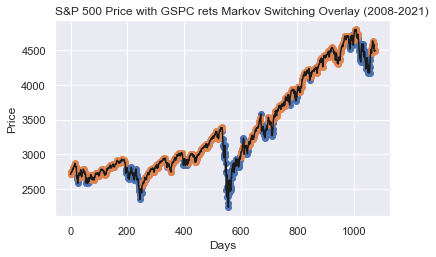

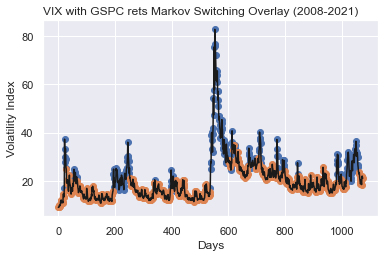

In [14]:
def plotHMM(data, hidden_states, ylabel= "y", title = "Chart"):
    sns.set()
    fig = plt.figure()
    subplt = fig.add_subplot(1,1,1)
    x = np.arange(len(data))
    
    unique_states = np.unique(hidden_states)
    for i in range(len(unique_states)):
        masks = hidden_states == unique_states[i]
        subplt.scatter(x[masks], data[masks], label= " ".join(["State", str(i+1)]))

    subplt.plot(x, data, c="k")
     
    subplt.set_xlabel('Days')
    subplt.set_ylabel(ylabel)
    subplt.set_title(title, loc="left")
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, ncol=2, frameon=True)
    plt.show() 
    return None

# plotHMM(gspc[1:][["close"]], gspc_markov_results[0])
# plotHMM(vix[1:][["close"]], gspc_markov_results[0])

# plotHMM(gspc[1:][["close"]], vix_markov_results[0])
# plotHMM(vix[1:][["close"]], vix_markov_results[0])

plotHMM(gspc[1:][["close"]], hidden_states_msdr_gspc, "Price", "S&P 500 Price with GSPC rets Markov Switching Overlay (2008-2021)")
plotHMM(vix[1:][["close"]], hidden_states_msdr_gspc, "Volatility Index", "VIX with GSPC rets Markov Switching Overlay (2008-2021)")


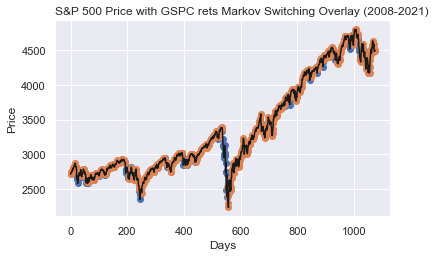

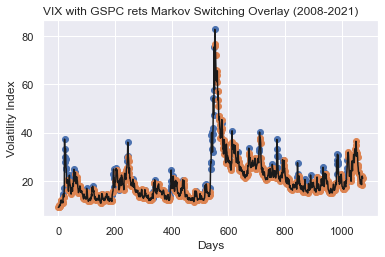

In [15]:
plotHMM(gspc[1:][["close"]], hidden_states_msdr_vix, "Price", "S&P 500 Price with GSPC rets Markov Switching Overlay (2008-2021)")
plotHMM(vix[1:][["close"]], hidden_states_msdr_vix, "Volatility Index", "VIX with GSPC rets Markov Switching Overlay (2008-2021)")

In [16]:
marg_probs_hgmm_vix = hgmm_model_vix.predict_proba(vix_pct[["close"]])
px.line(marg_probs_hgmm_vix[:, 0])

fig = make_subplots(rows=nRegimes+1, cols=1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = vix_pct["close"], x = vix_pct.index, name = "VIX % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_hgmm_vix[:, i], x = gspc_pct.index, name = "GSPC Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()


NameError: name 'hgmm_model_vix' is not defined

##### Higher Frequency Time Series
Examine whether classification using HMM works better with a higher frequency time series
Result: Patterns just don't exist in the short term (days, weeks). Use long term or very short term data to discern patterns.

In [24]:
df = pd.read_csv("Data\CME_MINI_ES1!, 60.csv", index_col=0)
df_pct = df.pct_change()[1:]
df_reshaped = np.reshape(df_pct[["Close"]], [len(df_pct[["Close"]]),1])

In [25]:
model_hf = GaussianHMM(n_components=nRegimes, n_iter=nIter).fit(df_reshaped)

hidden_states = model_hf.predict(df_reshaped)
mu = np.array(model_hf.means_)
sigma = np.array(np.sqrt(np.array([np.diag(model_hf.covars_[i]) for i in range(len(model_hf.covars_))])))
T = np.array(model_hf.transmat_)
# find log-likelihood of HMM
prob = model_hf.score(df_reshaped)

# results tuple for gspc markov
gspc_markov_hf_results = (hidden_states, mu, sigma, T, prob)
px.line(df["Close"])

In [17]:
hidden_states_msdr_vix.to_csv("hidden_states_msdr_vix.csv", index=True)

### QQQ States

In [29]:
first_date_qqq = "2001-01-22"
last_date_qqq = "2017-12-31"

qqq = YahooFinancials("QQQ")
qqq = qqq.get_historical_price_data(start_date=first_date_qqq, end_date=last_date_qqq, time_interval="daily")
qqq = pd.DataFrame(qqq["QQQ"]["prices"])
qqq = qqq.drop("date", axis=1).set_index("formatted_date")
qqq_pct = qqq.pct_change()[1:]

vix_qqq = YahooFinancials("^VXN")
vix_qqq = vix_qqq.get_historical_price_data(start_date=first_date_qqq, end_date=last_date_qqq, time_interval="daily")
vix_qqq = pd.DataFrame(vix_qqq["^VXN"]['prices'])
vix_qqq = vix_qqq.drop('date', axis=1).set_index('formatted_date')
vix_qqq_pct = vix_qqq.pct_change()[1:]

In [30]:
# params
nRegimes = 2
nIter = 1000

In [31]:
msdr_model_qqq = sm.tsa.MarkovRegression(endog=qqq_pct['close'], k_regimes=nRegimes,
    trend='c', switching_variance=True)

msdr_model_results_qqq = msdr_model_qqq.fit(iter=nIter)

marg_probs_msdr_qqq = [msdr_model_results_qqq.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style, title = "Markov Switching Regression Model (endog=QQQ rets, exog=VXN rets)")
fig.add_trace(
        go.Scatter(y = qqq_pct["close"], x = qqq_pct.index, name = "QQQ % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr_qqq[i], x = qqq_pct.index, name = "QQQ Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sidiy\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.



In [32]:
# hidden_states_msdr_qqq = (marg_probs_msdr_qqq[0] > .5)*1

hidden_states_msdr_qqq = (marg_probs_msdr_qqq[0] > .5)*1 + (marg_probs_msdr_qqq[1] > .5)*0 # + (marg_probs_msdr_qqq[2] > .5)*2
hidden_states_msdr_qqq

formatted_date
2001-01-23    0
2001-01-24    0
2001-01-25    0
2001-01-26    0
2001-01-29    0
             ..
2017-12-22    1
2017-12-26    1
2017-12-27    1
2017-12-28    1
2017-12-29    1
Length: 4262, dtype: int32

In [33]:
hidden_states_msdr_qqq.to_csv("qqq_hidden_states_01_17.csv", index=True)

In [40]:
vix_qqq

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2001-01-23,66.099998,58.419998,65.989998,58.570000,37500,58.570000
2001-01-24,61.450001,59.830002,60.000000,60.660000,37500,60.660000
2001-01-25,63.790001,61.790001,62.160000,63.480000,37500,63.480000
2001-01-26,66.080002,62.459999,65.930000,62.459999,37500,62.459999
2001-01-29,64.080002,62.009998,63.740002,62.400002,37500,62.400002
...,...,...,...,...,...,...
2017-12-22,13.140000,12.480000,13.120000,12.540000,0,12.540000
2017-12-26,14.350000,13.560000,14.330000,13.640000,0,13.640000
2017-12-27,14.440000,13.750000,14.060000,14.290000,0,14.290000


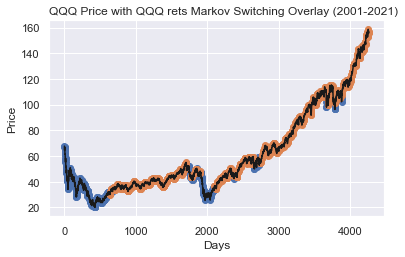

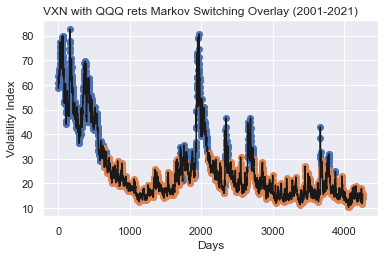

In [41]:
plotHMM(qqq[1:][["close"]], hidden_states_msdr_qqq, "Price", "QQQ Price with QQQ rets Markov Switching Overlay (2001-2021)")
plotHMM(vix_qqq[0:][["close"]], hidden_states_msdr_qqq, "Volatility Index", "VXN with QQQ rets Markov Switching Overlay (2001-2021)")

In [47]:
hidden_states_msdr_gspc

formatted_date
2018-01-03    1
2018-01-04    1
2018-01-05    1
2018-01-08    1
2018-01-09    1
             ..
2022-04-04    1
2022-04-05    1
2022-04-06    1
2022-04-07    1
2022-04-08    1
Name: 0, Length: 1075, dtype: int32